In [1]:
import tensorflow as tf
import numpy as np
import PIL.Image
import time
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import clear_output, display
from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

# Ensure TensorFlow version is 2.x
print(f"TensorFlow Version: {tf.__version__}")


Mounted at /content/drive
TensorFlow Version: 2.17.1


In [2]:
# Function to convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = tf.cast(tensor, tf.uint8)
    tensor = tensor.numpy()
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# Function to load and preprocess images
def load_img(path_to_img, max_dim=None):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    if max_dim:
        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim
        new_shape = tf.cast(shape * scale, tf.int32)
        img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# Function to display images
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

    plt.show()


In [3]:
# Parameters

# Choose model: 'VGG16', 'VGG19', 'InceptionV3'
model_name = 'VGG16'  # You can change this to 'VGG16' or 'InceptionV3'

# Paths to content and style images
content_image_path = '/content/drive/MyDrive/dev/pics/mac2.jpg'  # Replace with your content image path
style_image_path = '/content/drive/MyDrive/dev/pics/duncan_jago_unit.jpg'     # Replace with your style image path

# Adjust parameters
content_weight = 1e4
style_weight = 1e-1
total_variation_weight = 30
epochs = 10
steps_per_epoch = 20
max_dim = 512  # Max dimension of the images

# Ensure the paths are correct
assert os.path.exists(content_image_path), "Content image not found."
assert os.path.exists(style_image_path), "Style image not found."


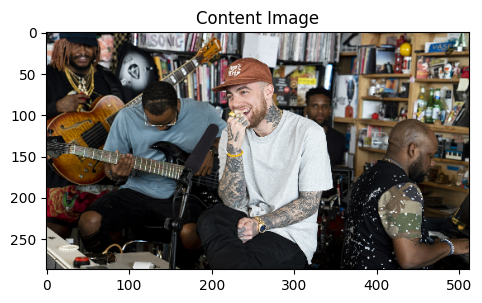

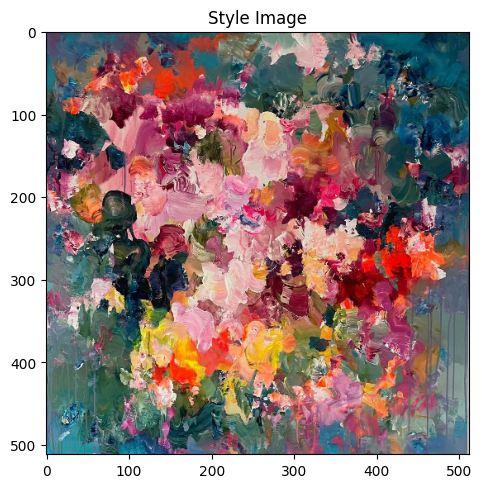

In [4]:
# Load the images
content_image = load_img(content_image_path, max_dim)
style_image = load_img(style_image_path, max_dim)

# Display the content and style images
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


In [5]:
# Function to get the model and preprocessing function
def get_model(model_name, style_layers, content_layers):
    if model_name == 'VGG16':
        base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
        preprocess_input = tf.keras.applications.vgg16.preprocess_input
    elif model_name == 'VGG19':
        base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        preprocess_input = tf.keras.applications.vgg19.preprocess_input
    elif model_name == 'InceptionV3':
        base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input
    else:
        raise ValueError("Model not supported. Choose 'VGG16', 'VGG19', or 'InceptionV3'.")

    base_model.trainable = False
    outputs = [base_model.get_layer(name).output for name in style_layers + content_layers]
    model = tf.keras.Model([base_model.input], outputs)
    return model, preprocess_input

# Define style and content layers for each model
if model_name == 'VGG16' or model_name == 'VGG19':
    # For VGG16 and VGG19
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1',
                    'block4_conv1',
                    'block5_conv1']
elif model_name == 'InceptionV3':
    # For InceptionV3
    content_layers = ['mixed7']
    style_layers = ['mixed0', 'mixed1', 'mixed2', 'mixed3']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Get the model and preprocessing function
model, preprocess_input = get_model(model_name, style_layers, content_layers)

print(f"Using {model_name} model for style transfer.")
print("Style Layers:")
for layer in style_layers:
    print(f" - {layer}")
print("Content Layers:")
for layer in content_layers:
    print(f" - {layer}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Function to compute gram matrix for style representation
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# Class to extract style and content
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, model, style_layers, content_layers, preprocess_input):
        super(StyleContentModel, self).__init__()
        self.model = model
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.preprocess_input = preprocess_input
        self.num_style_layers = len(style_layers)

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = self.preprocess_input(inputs)
        outputs = self.model(preprocessed_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

    # Add a method to get activations for visualization
    def get_style_activations(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = self.preprocess_input(inputs)
        outputs = self.model(preprocessed_input)
        style_outputs = outputs[:self.num_style_layers]
        return style_outputs

# Create an instance of the style and content extractor
extractor = StyleContentModel(model, style_layers, content_layers, preprocess_input)

# Extract style and content targets
style_targets = extractor(style_image)['style']
content_targets = extractor(style_image)['content']

# Function to get style activations
def get_style_activations(model, style_image):
    style_outputs = model.get_style_activations(style_image)
    return style_outputs

# Get the style activations
style_activations = get_style_activations(extractor, style_image)

In [ ]:
import math

def show_style_activations(activations, layer_names, num_channels=6):
    """
    Displays the activation maps for each style layer.

    Parameters:
    - activations: List of activation tensors.
    - layer_names: List of layer names corresponding to the activations.
    - num_channels: Number of channels to display for each layer.
    """
    for activation, layer_name in zip(activations, layer_names):
        num_features = activation.shape[-1]
        size = activation.shape[1]
        cols = num_channels
        rows = math.ceil(num_features / cols)
        display_grid = np.zeros((size * rows, size * cols, 3))

        for i in range(min(num_features, num_channels * rows)):
            row = i // cols
            col = i % cols
            channel_image = activation[0, :, :, i]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std() + 1e-5
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[row * size : (row + 1) * size,
                         col * size : (col + 1) * size, :] = np.stack([channel_image]*3, axis=-1)

        scale = 1. / size
        plt.figure(figsize=(cols * scale * 2, rows * scale * 2))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid)
        plt.show()

# Get the layer names
layer_names = style_layers

# Convert activations to numpy
style_activations_np = [activation.numpy() for activation in style_activations]

# Display the activations
show_style_activations(style_activations_np, layer_names, num_channels=6)

In [8]:
# Initialize the image to be optimized
image = tf.Variable(content_image)

# Define the optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Function to compute style and content loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# Function to perform a training step
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))


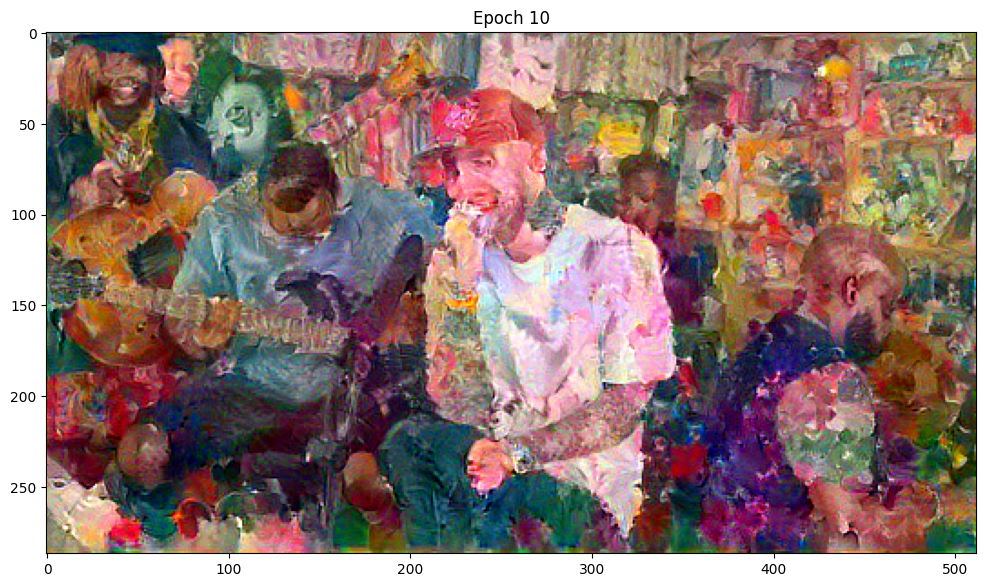

Total time: 967.7 seconds


In [9]:
start_time = time.time()

for n in range(epochs):
    print(f"Epoch {n+1}/{epochs}")
    for m in range(steps_per_epoch):
        train_step(image)
        print('.', end='')
    print()
    # Display intermediate result
    clear_output(wait=True)
    imshow(image.read_value(), title=f"Epoch {n+1}")
    # Optionally save intermediate images
    intermediate_image = tensor_to_image(image)
    intermediate_image.save(f"output_epoch_{n+1}.png")

total_time = time.time() - start_time
print(f"Total time: {total_time:.1f} seconds")
